### Import Dataset


In [43]:
import deeplake
from deeplake import Dataset
from random import randint
from skimage.color import rgb2gray

ds: Dataset = deeplake.load("hub://activeloop/icdar-2013-text-localize-train")

|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/icdar-2013-text-localize-train



/

hub://activeloop/icdar-2013-text-localize-train loaded successfully.



### Plotting Images


In [44]:
from math import ceil, sqrt
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 10)


def dims(i):
    c = ceil(sqrt(i))
    r = ceil(i / c)
    return r, c


def plot(images, cmap="gray", titles=[]):
    r, c = dims(len(images))
    _, ax = plt.subplots(r, c)

    if len(images) > 1:
        ax = ax.ravel()
        for i, img in enumerate(images):
            ax[i].imshow(img, cmap=cmap)
            ax[i].set_axis_off()
            if len(titles) > 0:
                ax[i].set_title(titles[i])
    else:
        ax.imshow(images[0], cmap=cmap)
        ax.set_axis_off()
        if len(titles) > 0:
            ax.set_title(titles[0])
    plt.tight_layout()
    plt.show()

### Denoising


[0.04, 0.07, 0.1, 0.13000000000000003, 0.16000000000000003, 0.19000000000000003]


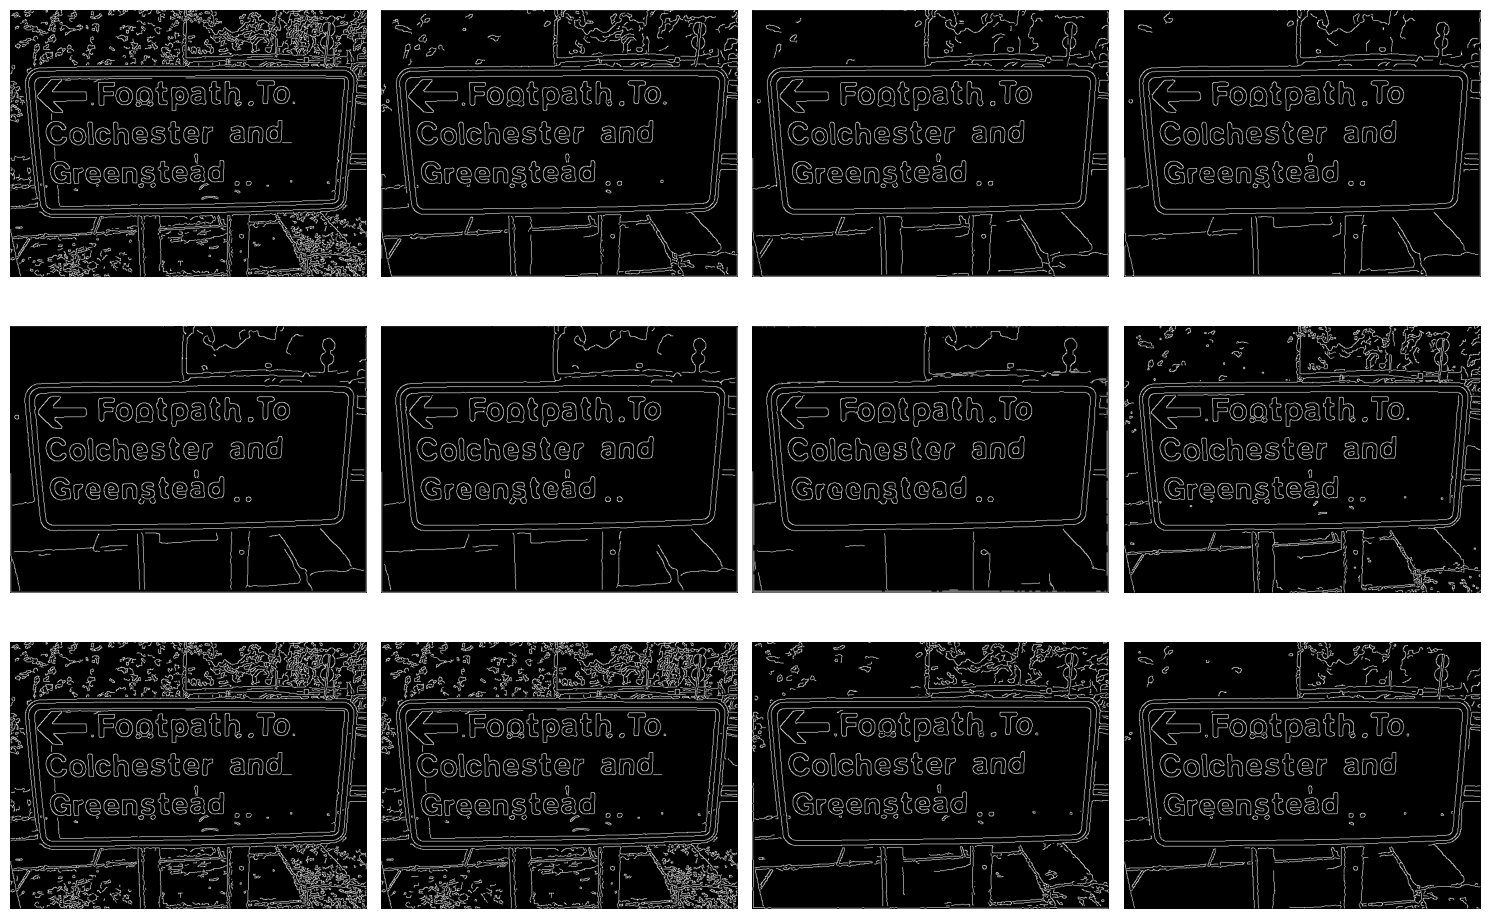

In [102]:
from cv2.ximgproc import (
    anisotropicDiffusion,
    guidedFilter,
    jointBilateralFilter,
    weightedMedianFilter,
)

from skimage.restoration import denoise_bilateral, denoise_tv_chambolle
import numpy as np


# idx = randint(0, 230)
idx = 0
img = ds.images[idx].numpy()

anis = [anisotropicDiffusion(img, i, 100, 10) for i in np.arange(0.04, 0.2, 0.03)]
print([i for i in np.arange(0.04, 0.22, 0.03)])
denoised = [
    img,
    *anis,
    weightedMedianFilter(img, img, r=5),
    jointBilateralFilter(img, img, d=5, sigmaColor=5, sigmaSpace=5),
    guidedFilter(img, img, 5, 5),
    denoise_bilateral(img, channel_axis=-1),
    denoise_tv_chambolle(img),
]

# edge detection
# ------------------------------------------------------------------------------

from skimage.feature import canny

edge_maps = list(map(canny, map(rgb2gray, denoised)))
plot(edge_maps)

### tests


In [100]:
from skimage.draw import rectangle

ground_truth = edge_maps[0].copy()
boxes = ds.boxes[idx]["box"].numpy()

xnor = []

for edge_map in edge_maps:
    xnor_areas = np.zeros_like(edge_map)
    remaining_areas = edge_map.copy()

    gt_sum_edge_pixels = 0
    mod_sum_edge_pixels = 0
    sum_pixels_in_boxes = 0
    xnor_pixels = 0
    img_dims = ()
    remaining_sum_pixels = 0

    for box in boxes:
        x1, y1, x2, y2 = box
        rr, cc = rectangle(start=(int(y1), int(x1)), end=(int(y2), int(x2)))

        gt_sum_edge_pixels += np.sum(ground_truth[rr, cc])
        mod_sum_edge_pixels += np.sum(edge_map[rr, cc])
        sum_pixels_in_boxes += edge_map[rr, cc].shape[0] * edge_map[rr, cc].shape[1]
        xnor_areas[rr, cc] = edge_map[rr, cc] ^ ~ground_truth[rr, cc]
        xnor_pixels += np.sum(xnor_areas[rr, cc])
        remaining_areas[rr, cc] = 0

        xnor.append(xnor_areas)

    img_dims = edge_map.shape[0] * edge_map.shape[1]
    remaining_sum_pixels += np.sum(remaining_areas)

    # print("Ground truth sum pixels: ", gt_sum_edge_pixels)
    # print("Modified sum pixels: ", mod_sum_edge_pixels)
    # print("Sum pixels in boxes: ", sum_pixels_in_boxes)
    # print("Xnor pixels: ", xnor_pixels)
    # print("Remaining pixels: ", remaining_sum_pixels)
    # print("Image dimensions: ", img_dims)
# plot(xnor)

### Data Logging


In [108]:
import mysql.connector

# credentials
host = "10.0.0.168"
user = "root"
password = "31656072"
database = "swt_denoising_results"

try:
    # Create a connection to the database
    cnx = mysql.connector.connect(
        host=host, user=user, password=password, database=database
    )

    # Check if the connection is successful
    if cnx.is_connected():
        print("Connected to the database.")
    else:
        print("Failed to connect to the database.")

except mysql.connector.Error as err:
    print("Error connecting to the database:", err)

Error connecting to the database: 2003 (HY000): Can't connect to MySQL server on '10.0.0.168:3306' (10060)
